In [10]:
%load_ext autoreload
%autoreload 2
import sys
#sys.path.append('/home/hpc-rosneft/drigo/surrogate/src/')
sys.path.append('/Users/drigo/ITMO/_disser/surrogate/src/')
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_squared_error as mse

from dataset import load_variable_years
from _main import Main
from tools import Logger

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams["date.autoformatter.year"] = "%Y"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.style.use('seaborn-whitegrid')
from mpl_toolkits.basemap import Basemap

from netcdftools import MyNetCDF
from viz import Plot
import dataset as dset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
lats = np.load('/Users/drigo/ITMO/_disser/surrogate/data/lats.npy')
lons = np.load('/Users/drigo/ITMO/_disser/surrogate/data/lons.npy')
def plot_map(data2d, step=None, lats=lats, lons=lons, vmin=0, vmax=1):
    m = Basemap(projection='npstere', boundinglat=60, lon_0=0, resolution='i')
    
    if step is not None:
        lats = lats[::step[0],::step[1]]
        lons = lons[::step[0],::step[1]]
        data2d = data2d[::step[0],::step[1]]
    xi, yi = m(lons, lats)
        
    # m.drawparallels(np.arange(-80.,81.,20.), linewidth=0.8)
    # m.drawmeridians(np.arange(-180.,181.,20.), linewidth=0.8)
    # Add Coastlines, States, and Country Boundaries
    # m.drawlsmask(land_color='c', ocean_color='w', lsmask=None)
    m.fillcontinents()
    m.drawmapboundary(fill_color='white')
    m.drawcountries()
    # cmp = cm.get_cmap('rainbow', 11)
    my_cmap = plt.get_cmap('RdBu_r')
    my_cmap.set_bad('white')
    m.pcolormesh(xi, yi, data2d, cmap=my_cmap, vmin=vmin, vmax=vmax)
    m.colorbar()
def apply2dmask(array3d, mask2d):
    mask = np.broadcast_to(mask2d, array3d.shape)
    array3d[~mask]=np.nan
    res = array3d
    return res

In [6]:
#step=[1,1]

ice_sat = dset.load_variable_years('thick_cr2smos',[2014,2015])
ice_line = np.load('/Users/drigo/ITMO/_disser/surrogate/data/ice_mask.npy')

res = np.load('/Users/drigo/ITMO/_disser/surrogate/data/results/res_1222_0754_comp.npy')
NEMO = dset.load_variable_years('icethic_cea', [2014, 2015])

res = apply2dmask(res, ice_line)
ice_sat = apply2dmask(ice_sat, ice_line)
NEMO = apply2dmask(NEMO, ice_line)

Text(0.5, 1.0, 'Data-driven model: Mean sea-ice thickness in years 2014-2015, m')

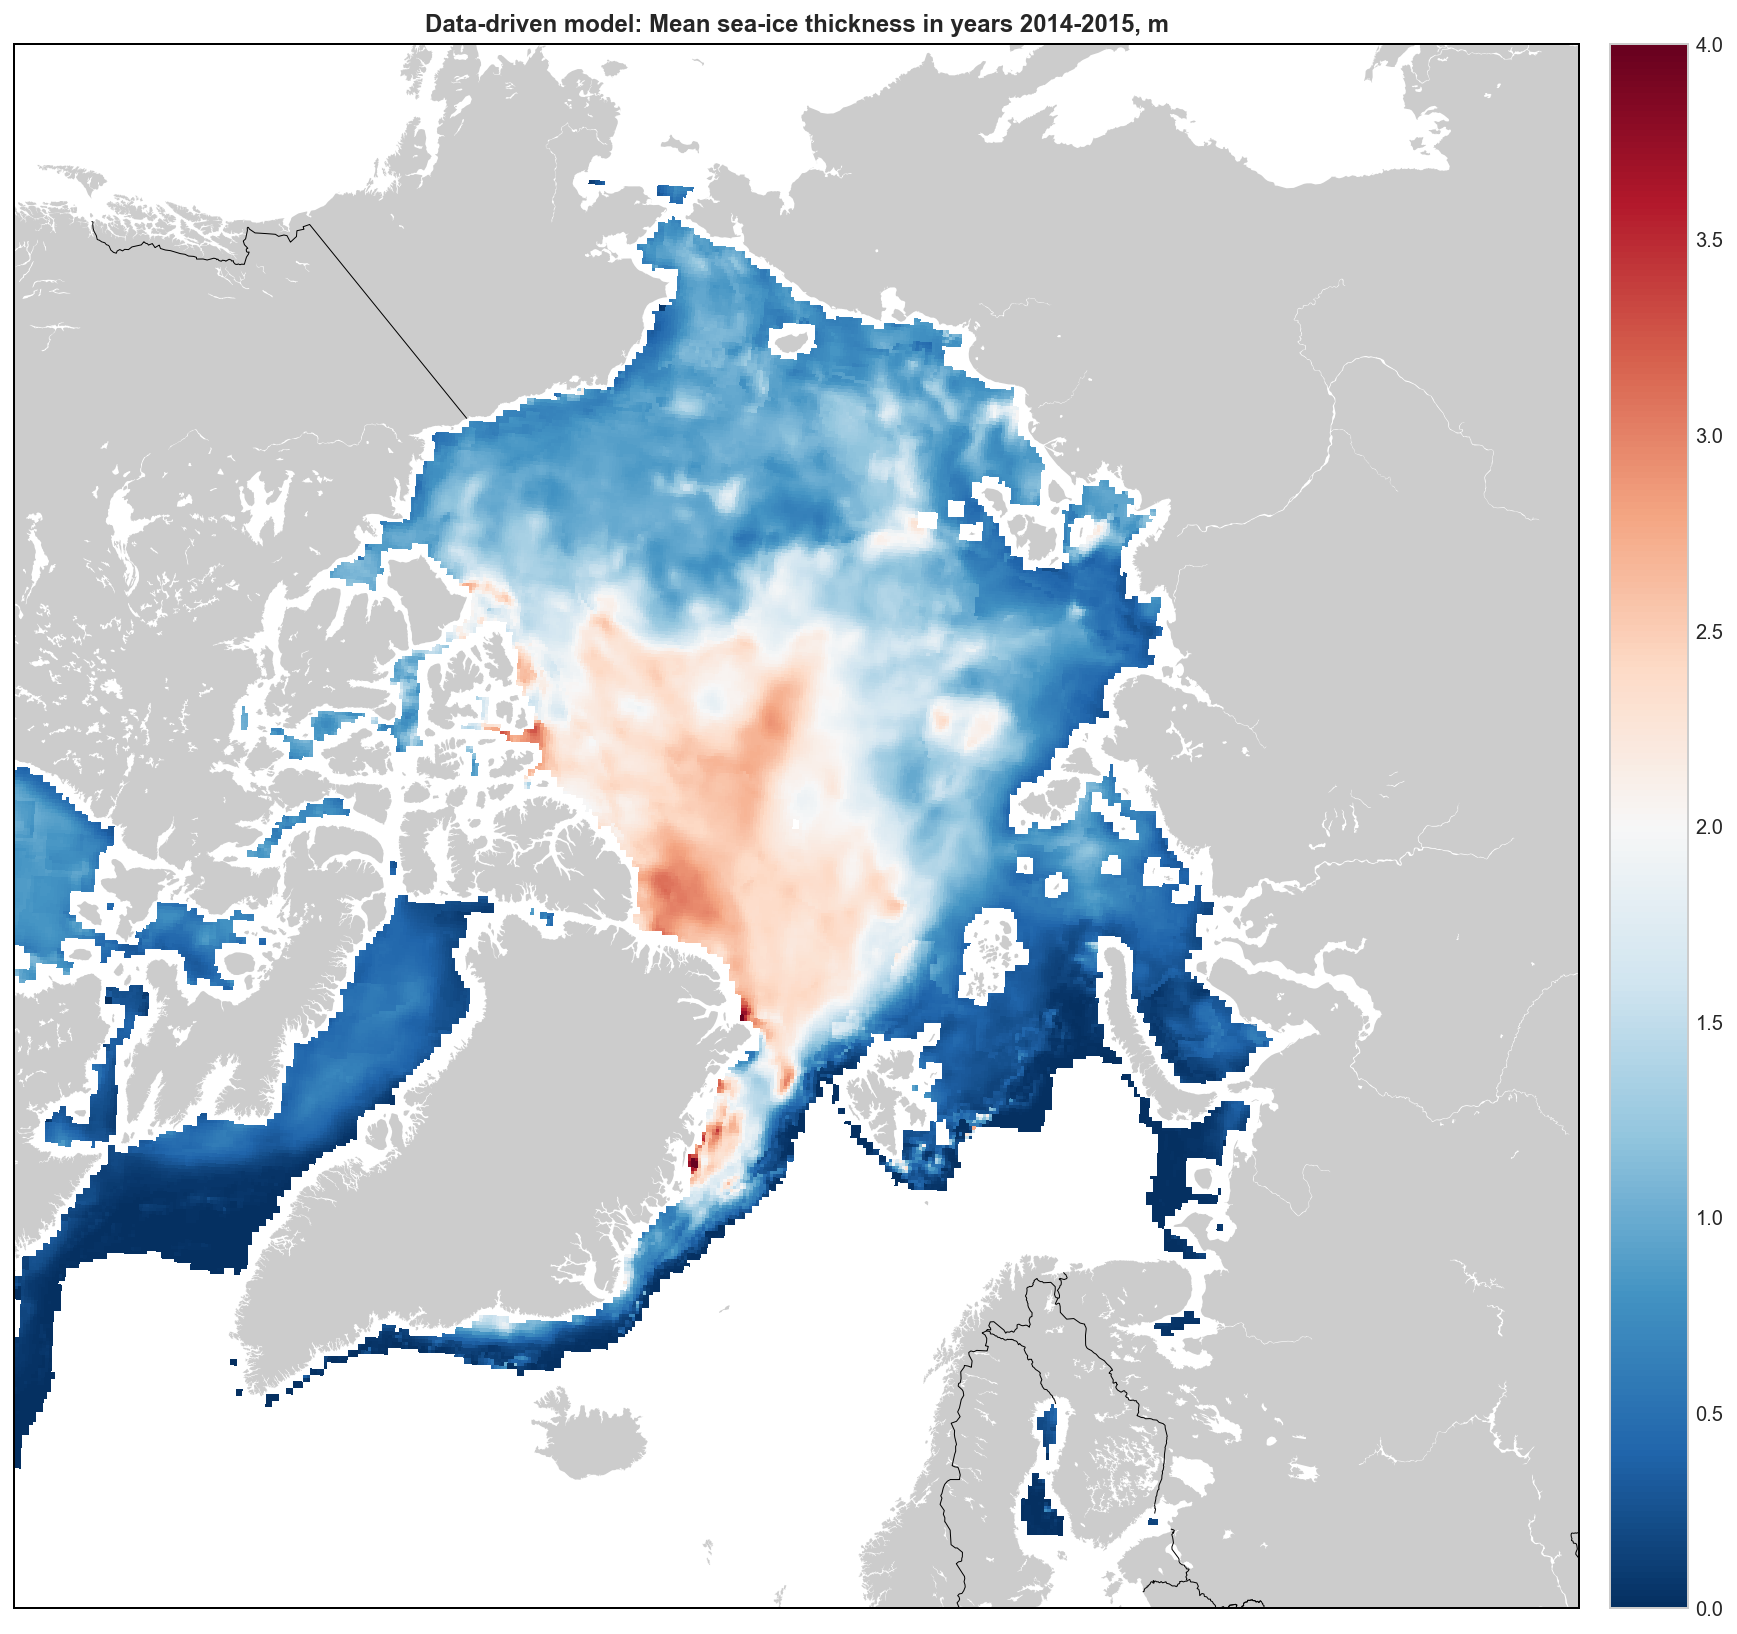

In [11]:
plot_map(np.nanmean(res[:], axis=0), vmin=0, vmax=4)
plt.title('Data-driven model: Mean sea-ice thickness in years 2014-2015, m', weight='bold')

Text(0.5, 1.0, 'NEMO: Mean sea-ice thickness in years 2014-2015, m')

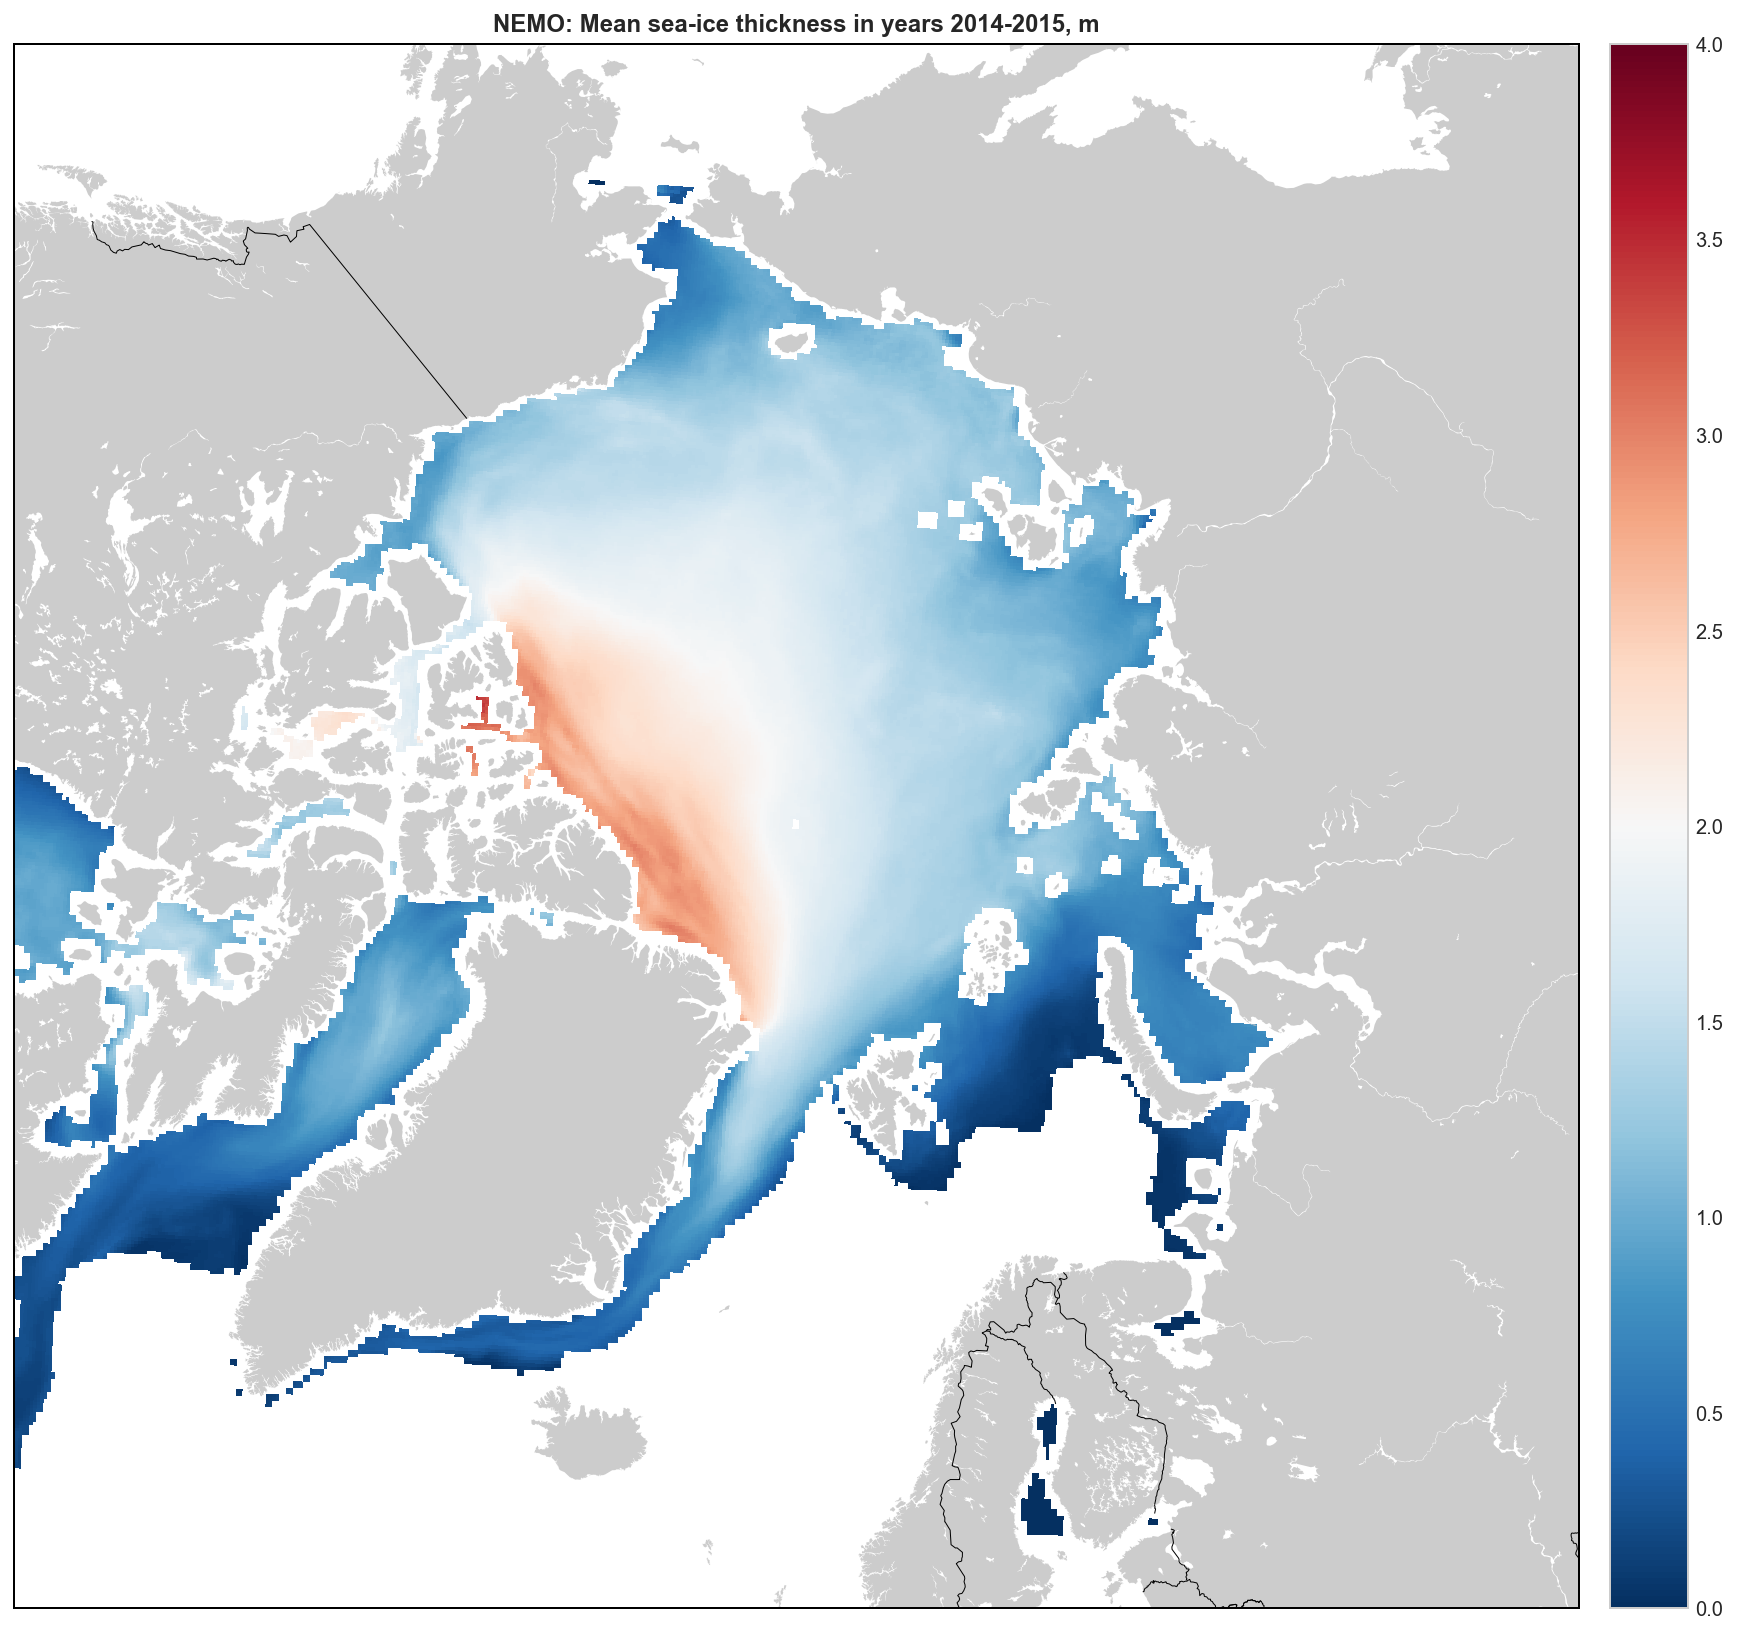

In [12]:
plot_map(np.nanmean(NEMO, axis=0), vmin=0, vmax=4)
plt.title('NEMO: Mean sea-ice thickness in years 2014-2015, m', weight='bold')

Text(0.5, 1.0, 'Sattelite observations: Mean sea-ice thickness in years 2014-2015, m')

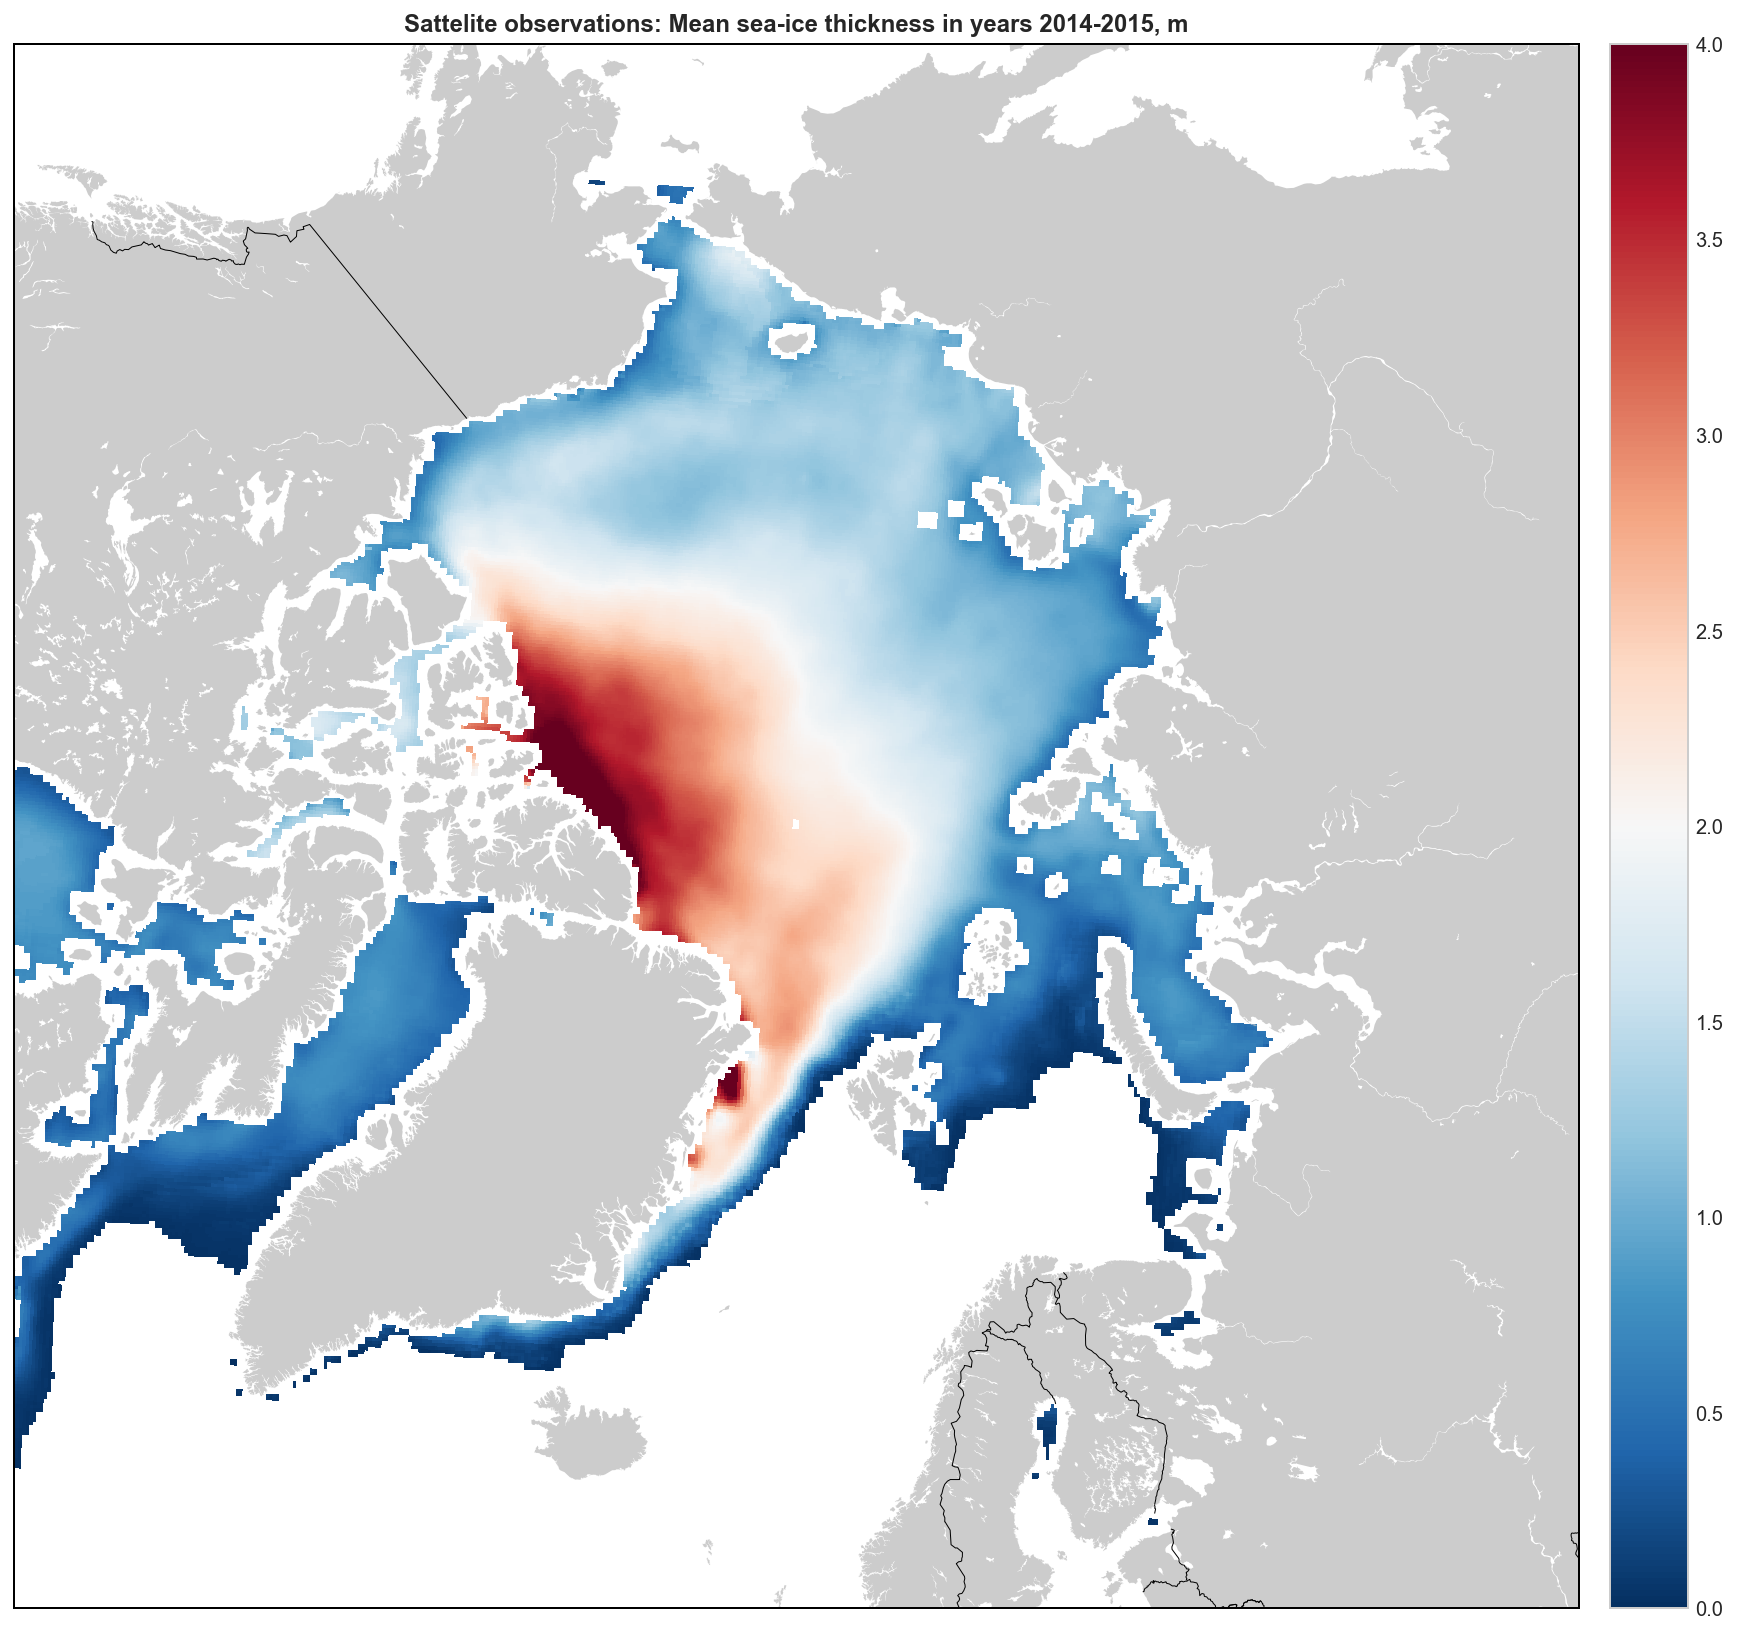

In [13]:
plot_map(np.nanmean(ice_sat, axis=0), vmin=0, vmax=4)
plt.title('Sattelite observations: Mean sea-ice thickness in years 2014-2015, m',weight='bold')

In [74]:
def rmse(a1, a2):
    return (np.nanmean(np.power(a1-a2, 2)))

def MAE(a1, a2):
    return np.nanmean(abs(a1-a2))

rmse_NEMO_sat = []
rmse_prediction_sat = []
rmse_prediction_nemo = []
mae_NEMO_sat = []
mae_prediction_sat = []
mae_prediction_nemo = []
for t in range(res.shape[0]):
    rmse_NEMO_sat.append(rmse(NEMO[t,:,:], ice_sat[t,:,:]))
    rmse_prediction_sat.append(rmse(res[t,:,:], ice_sat[t,:,:]))
    rmse_prediction_nemo.append(rmse(res[t,:,:], NEMO[t,:,:]))
    
    mae_NEMO_sat.append(MAE(NEMO[t,:,:], ice_sat[t,:,:]))
    mae_prediction_sat.append(MAE(res[t,:,:], ice_sat[t,:,:]))
    mae_prediction_nemo.append(MAE(res[t,:,:], NEMO[t,:,:]))

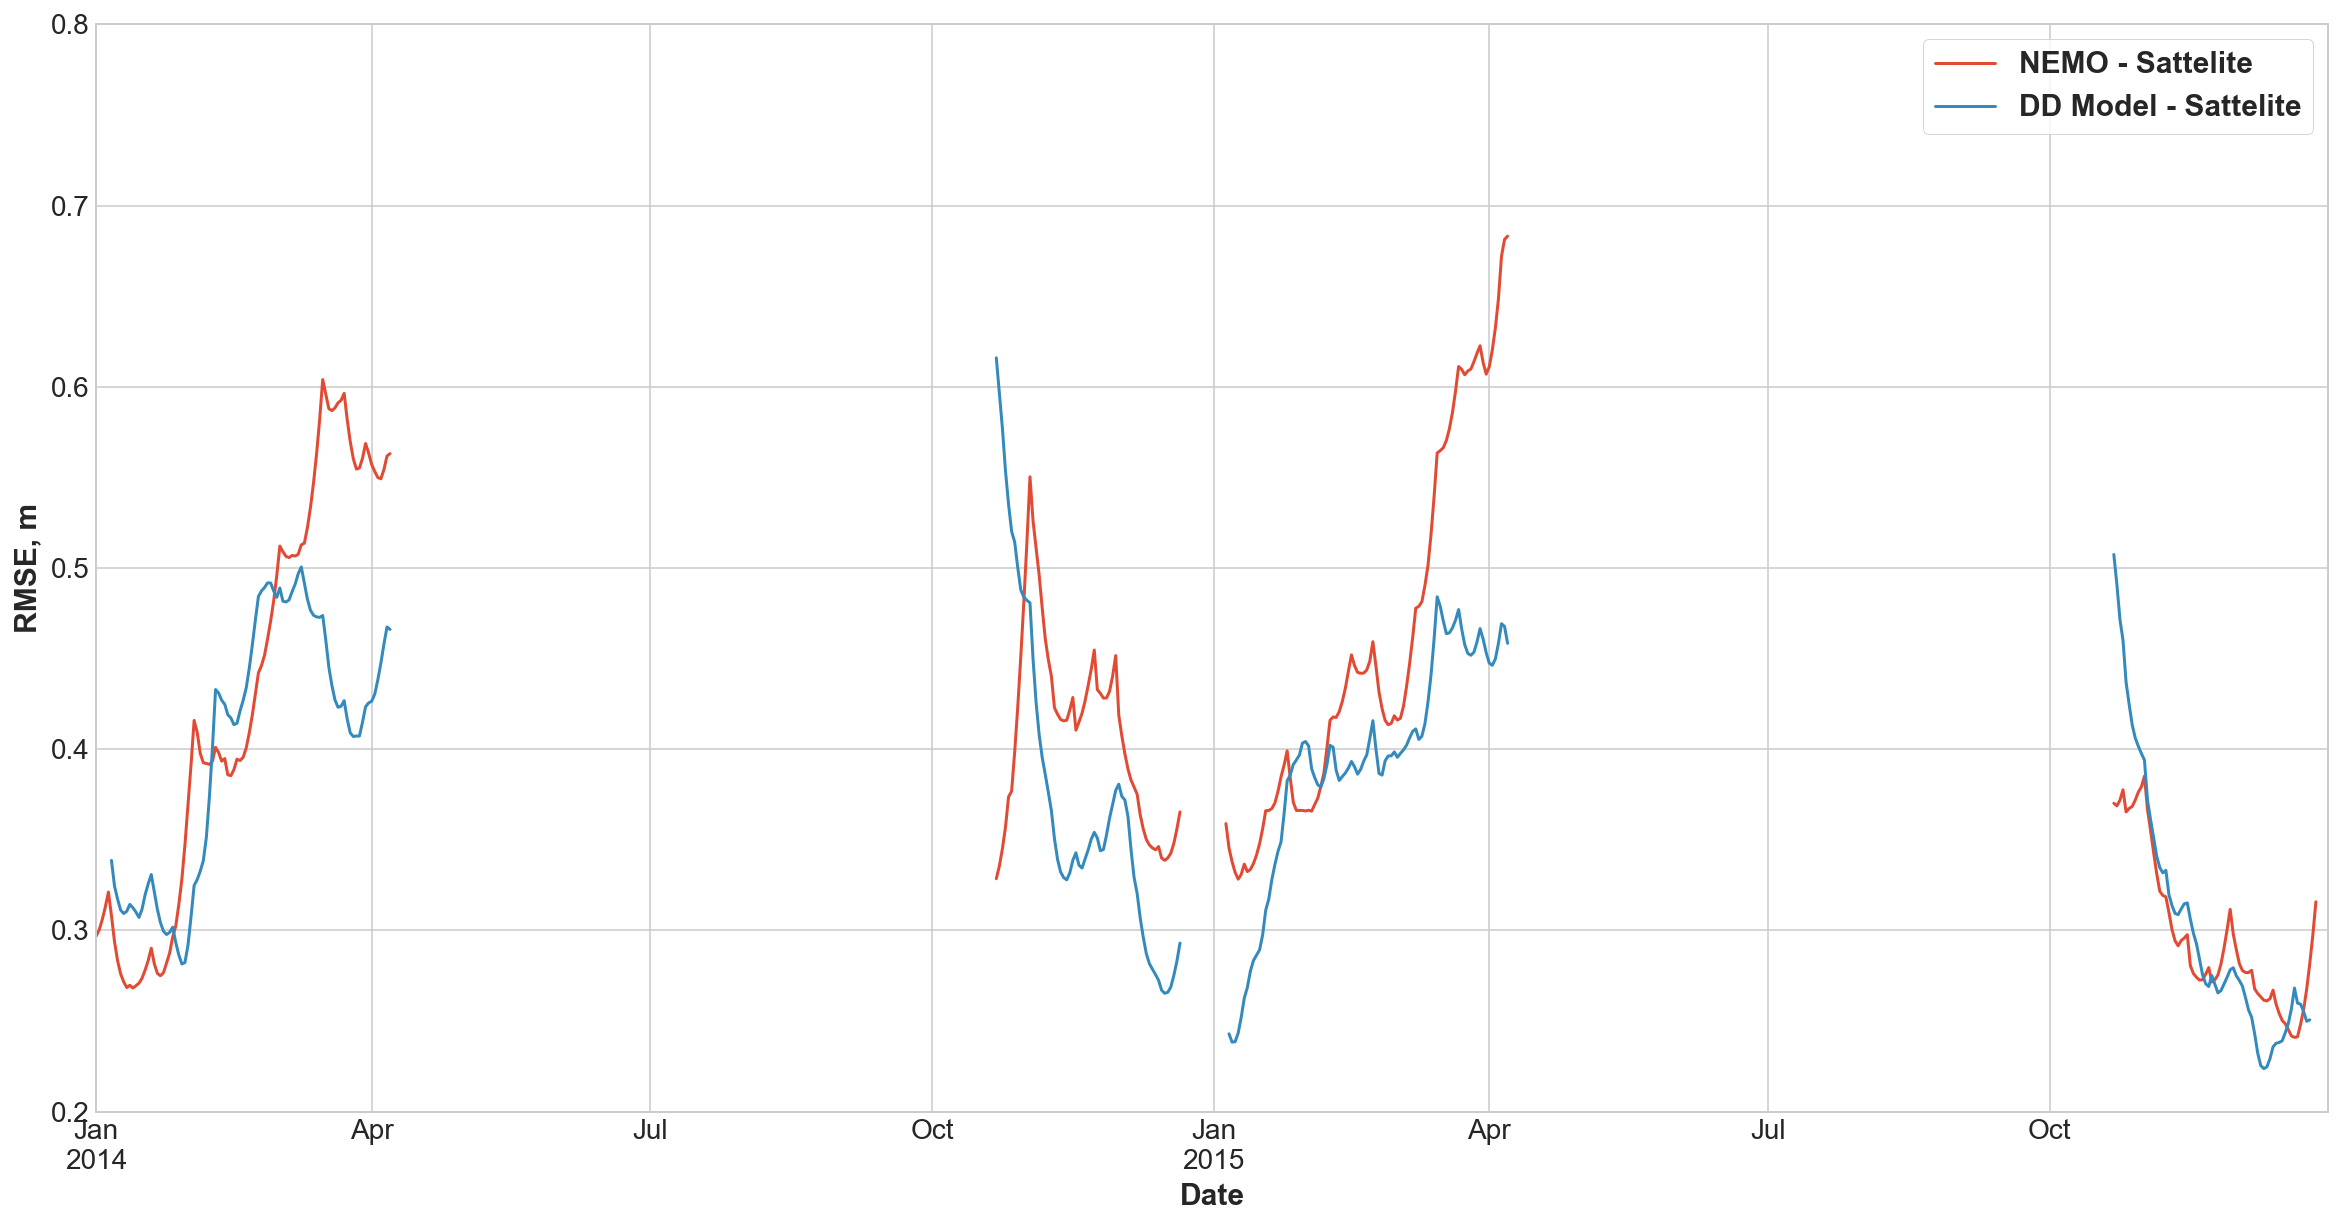

In [98]:
from scipy import stats
plt.rcParams['figure.figsize'] = [20, 10]
dates = pd.date_range('01/01/2014', '31/12/2015',freq='D')
rmse_df = pd.DataFrame({'NEMO - Sattelite':rmse_NEMO_sat,
                       'DD Model - Sattelite':rmse_prediction_sat,
                       'DD Model - NEMO':rmse_prediction_nemo}, index=dates)

rmse_df['DD Model - Sattelite'][rmse_df['DD Model - Sattelite']>1]=np.nan
rmse_df[['NEMO - Sattelite','DD Model - Sattelite']].plot()

axes = plt.gca()
axes.set_ylim([0.2,0.8])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Date',fontsize = 15, weight = 'bold')
plt.ylabel('RMSE, m',fontsize = 15, weight = 'bold')
plt.legend(loc=1, prop={'size': 15,'weight':'bold'}, frameon=True)

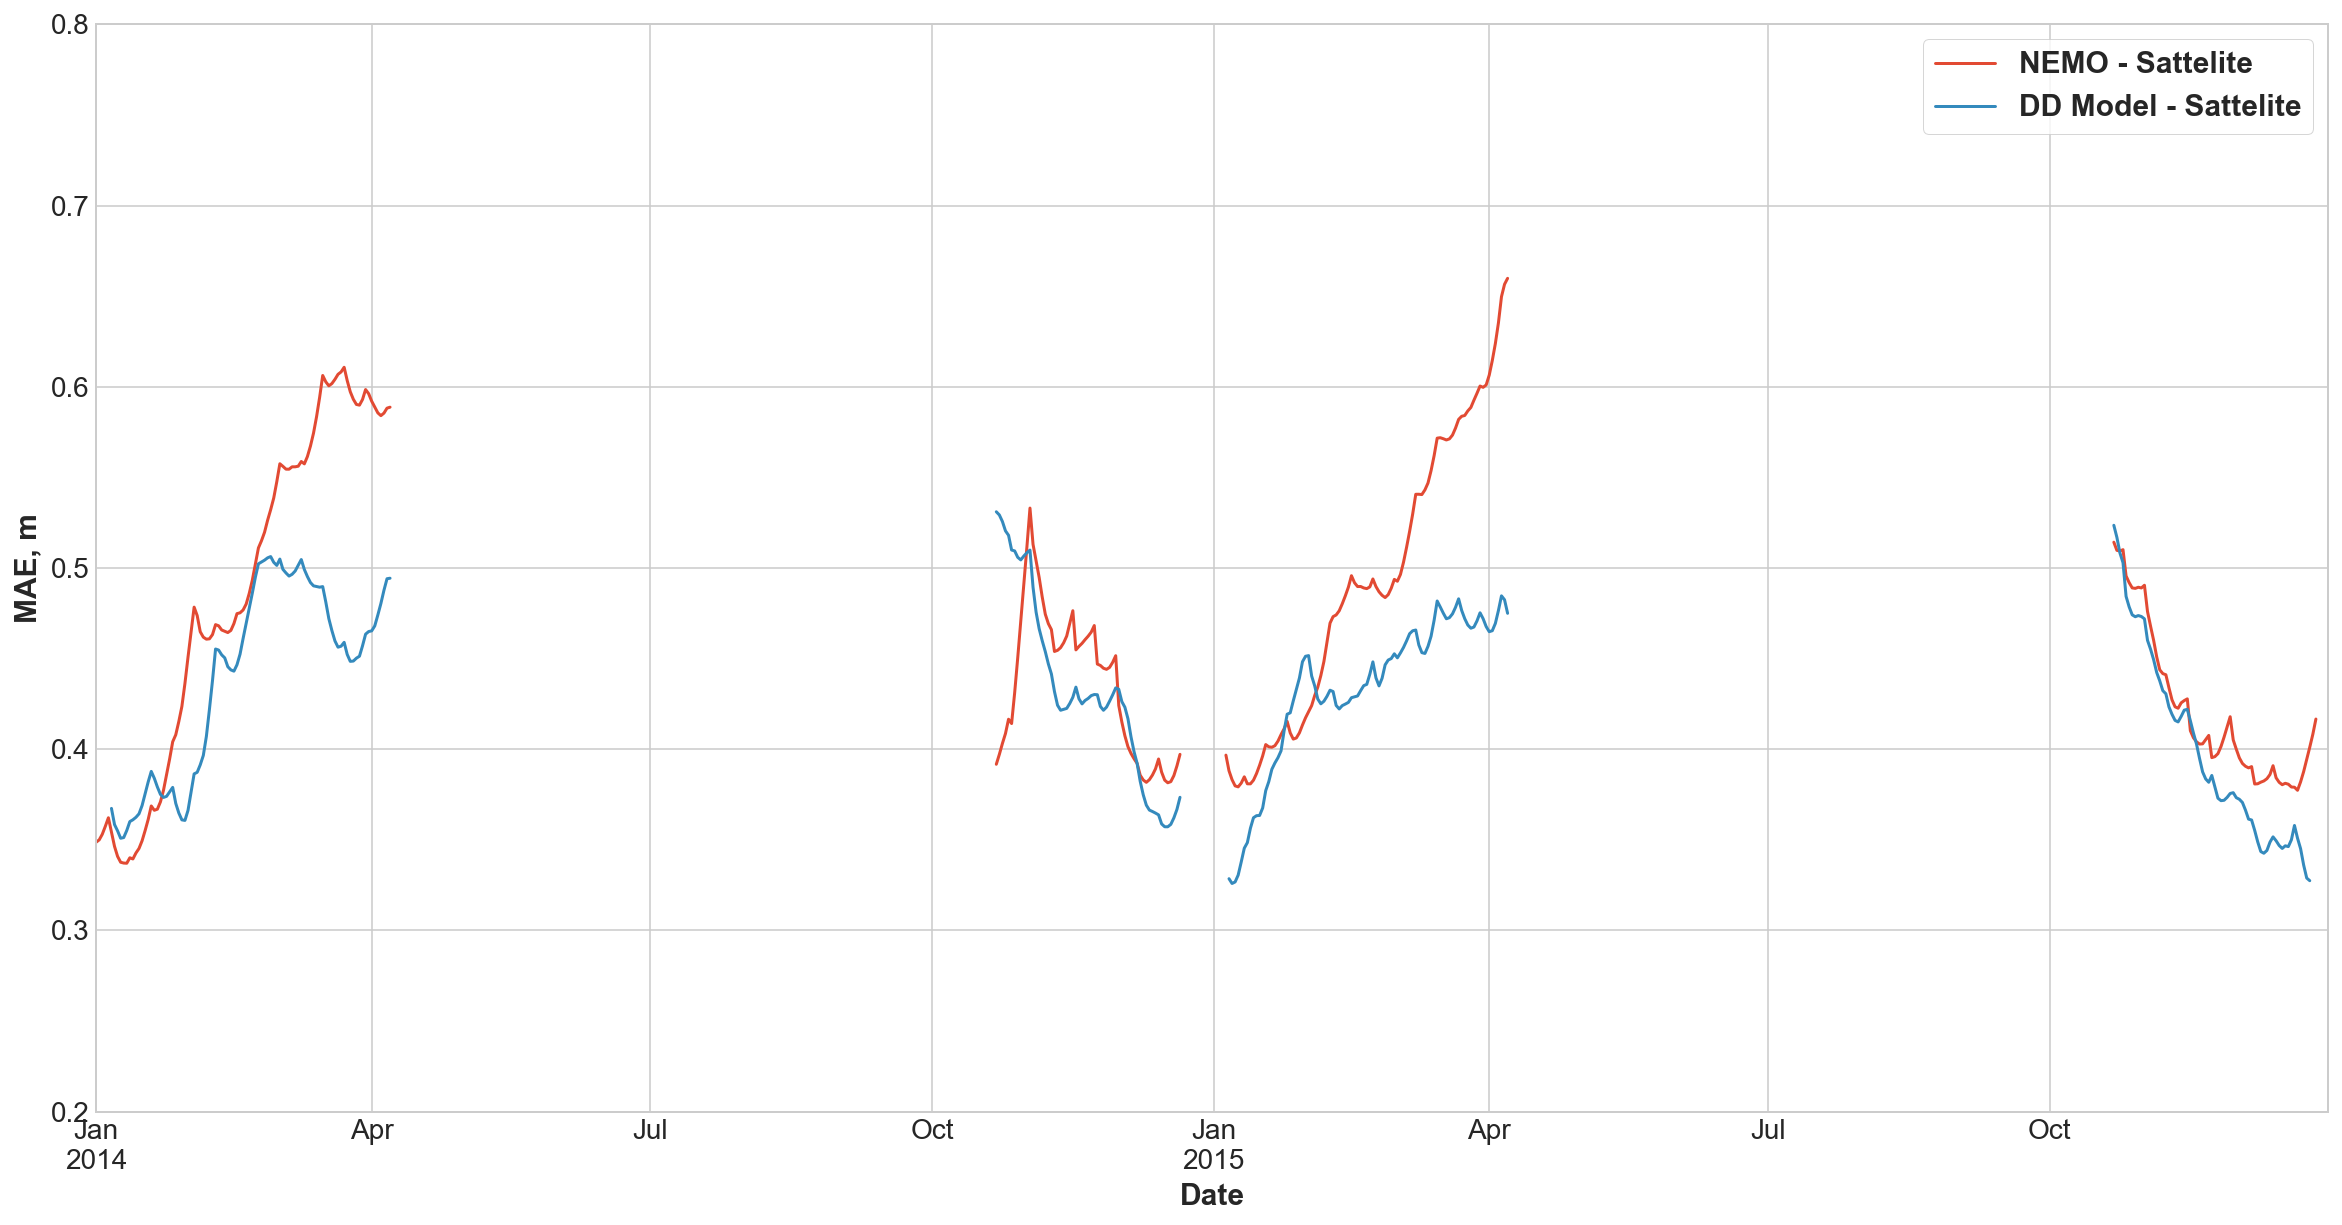

In [99]:
plt.rcParams['figure.figsize'] = [20, 10]
mae_df = pd.DataFrame({'NEMO - Sattelite':mae_NEMO_sat,
                       'DD Model - Sattelite':mae_prediction_sat,
                       'DD Model - NEMO':mae_prediction_nemo}, index=dates)

mae_df['DD Model - Sattelite'][mae_df['DD Model - Sattelite']>1]=np.nan
mae_df[['NEMO - Sattelite','DD Model - Sattelite']].plot()

axes = plt.gca()
axes.set_ylim([0.2,0.8])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Date',fontsize = 15, weight = 'bold')
plt.ylabel('MAE, m',fontsize = 15, weight = 'bold')
plt.legend(loc=1, prop={'size': 15,'weight':'bold'}, frameon=True)

In [40]:
def rmse3d(a1,a2):
    return np.nanmean(np.power(a1-a2, 2), axis=0)
def MAE3d(a1,a2):
    return np.nanmean(abs(a1-a2), axis=0)

Text(0.5, 1.0, 'Mean absolute error of sea-ice thickness 2014-2015, m')

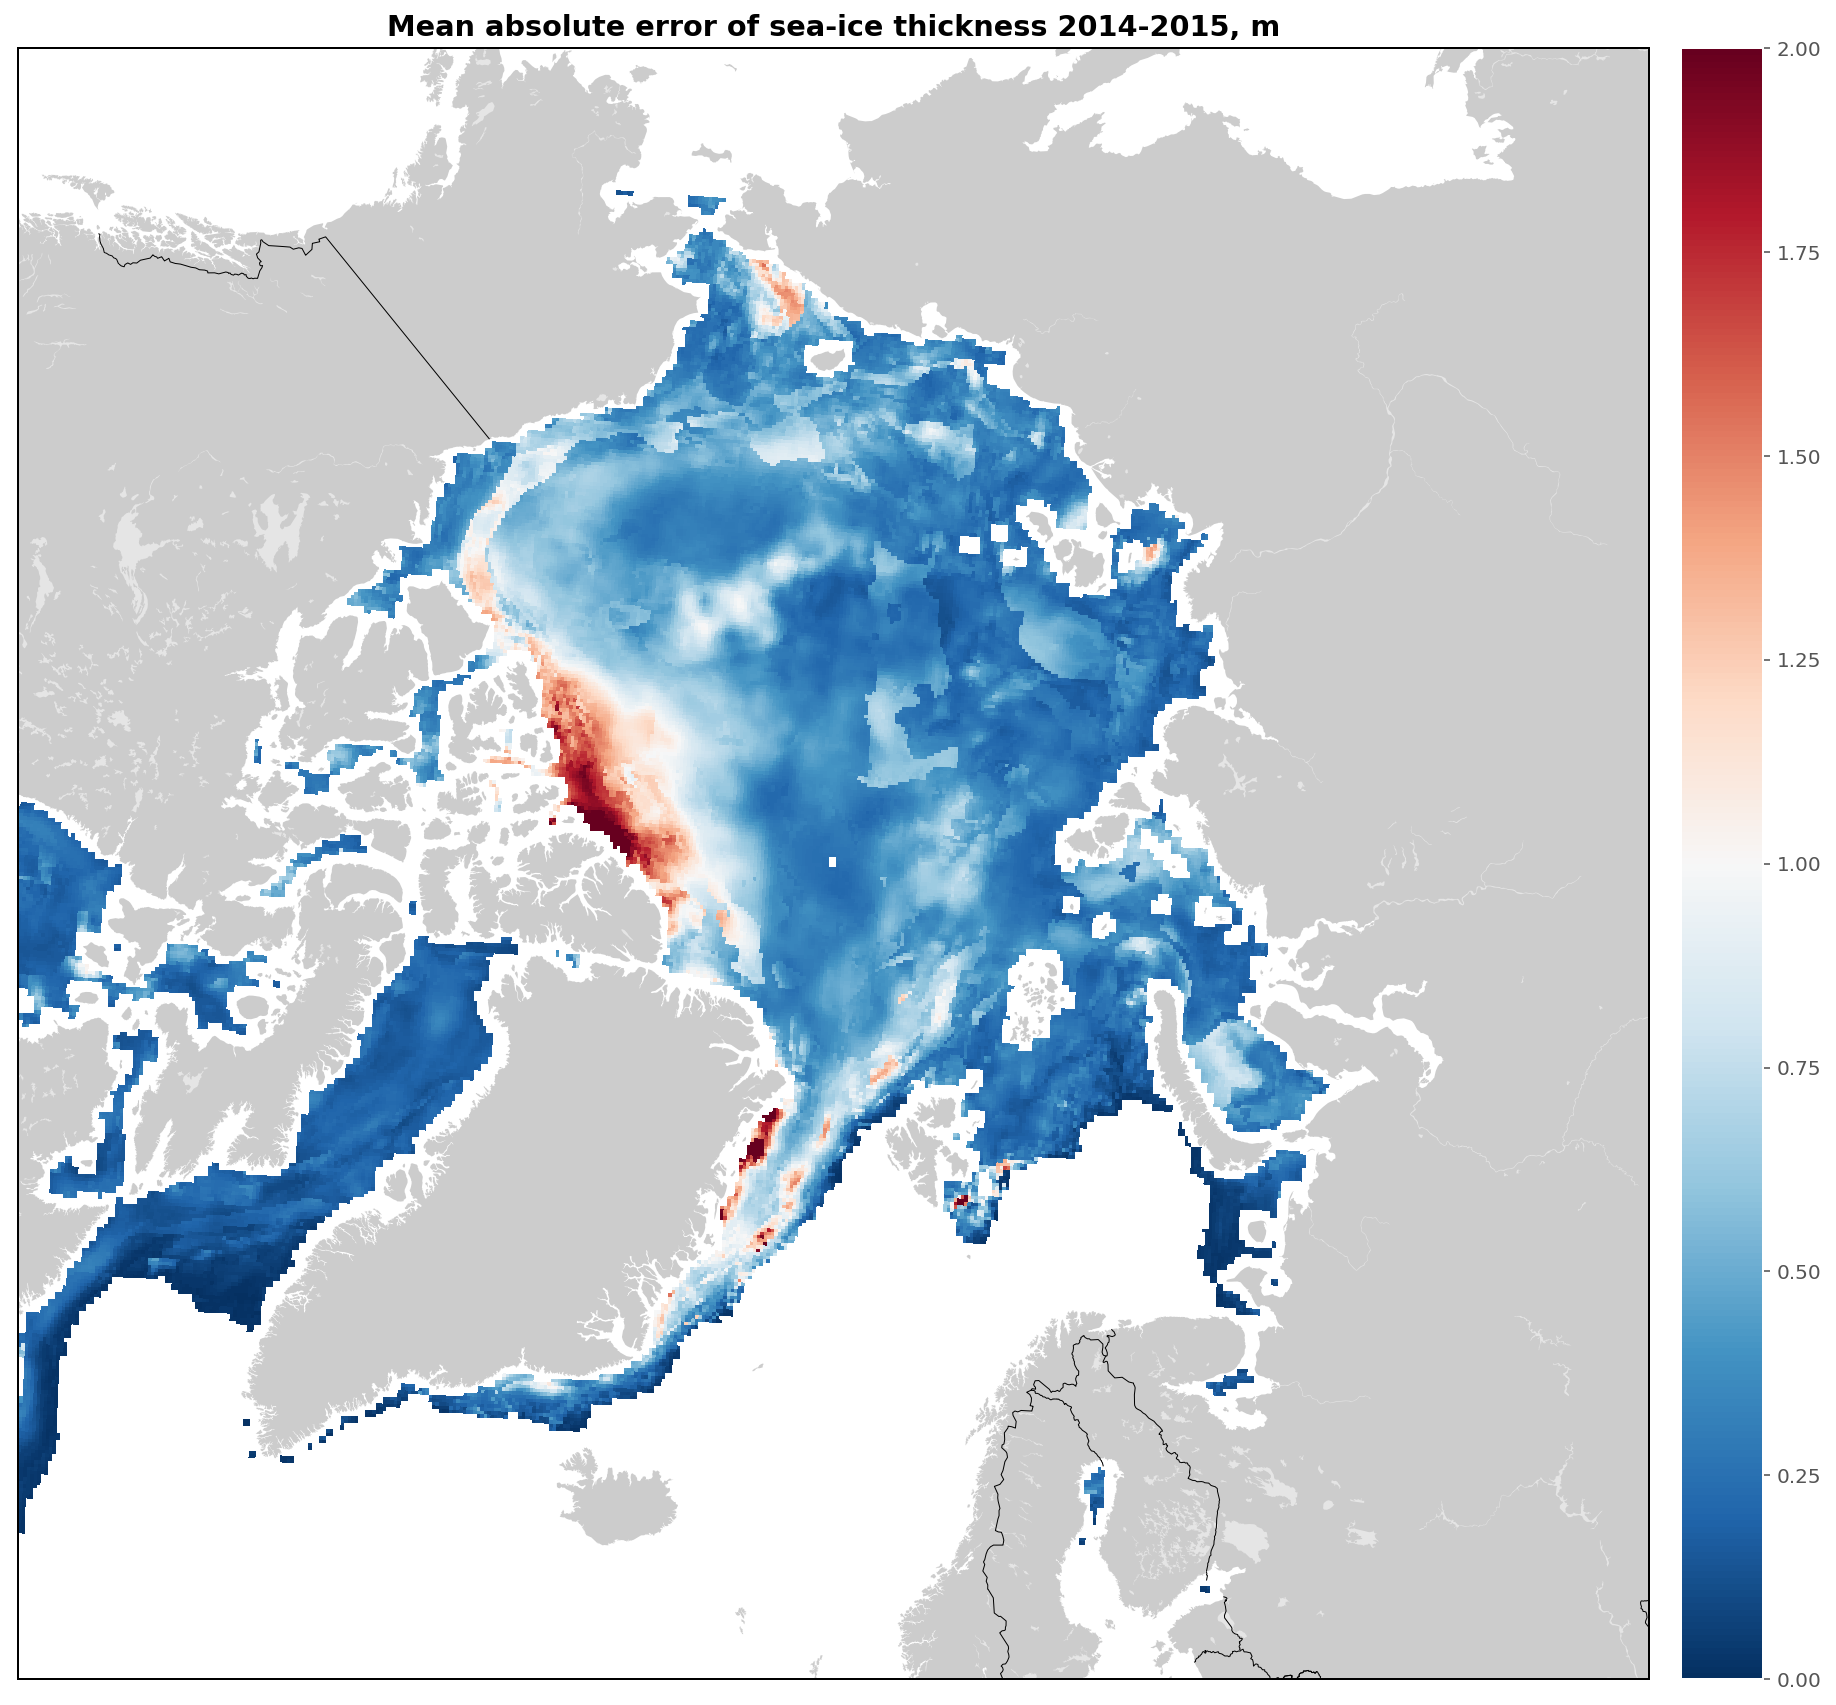

In [56]:
plot_map(MAE3d(ice_sat, res), vmin=0, vmax=2)
plt.title('Mean absolute error of sea-ice thickness 2014-2015, m',  weight = 'bold')

Text(0.5, 1.0, 'Root mean square error of sea-ice thickness 2014-2015, m')

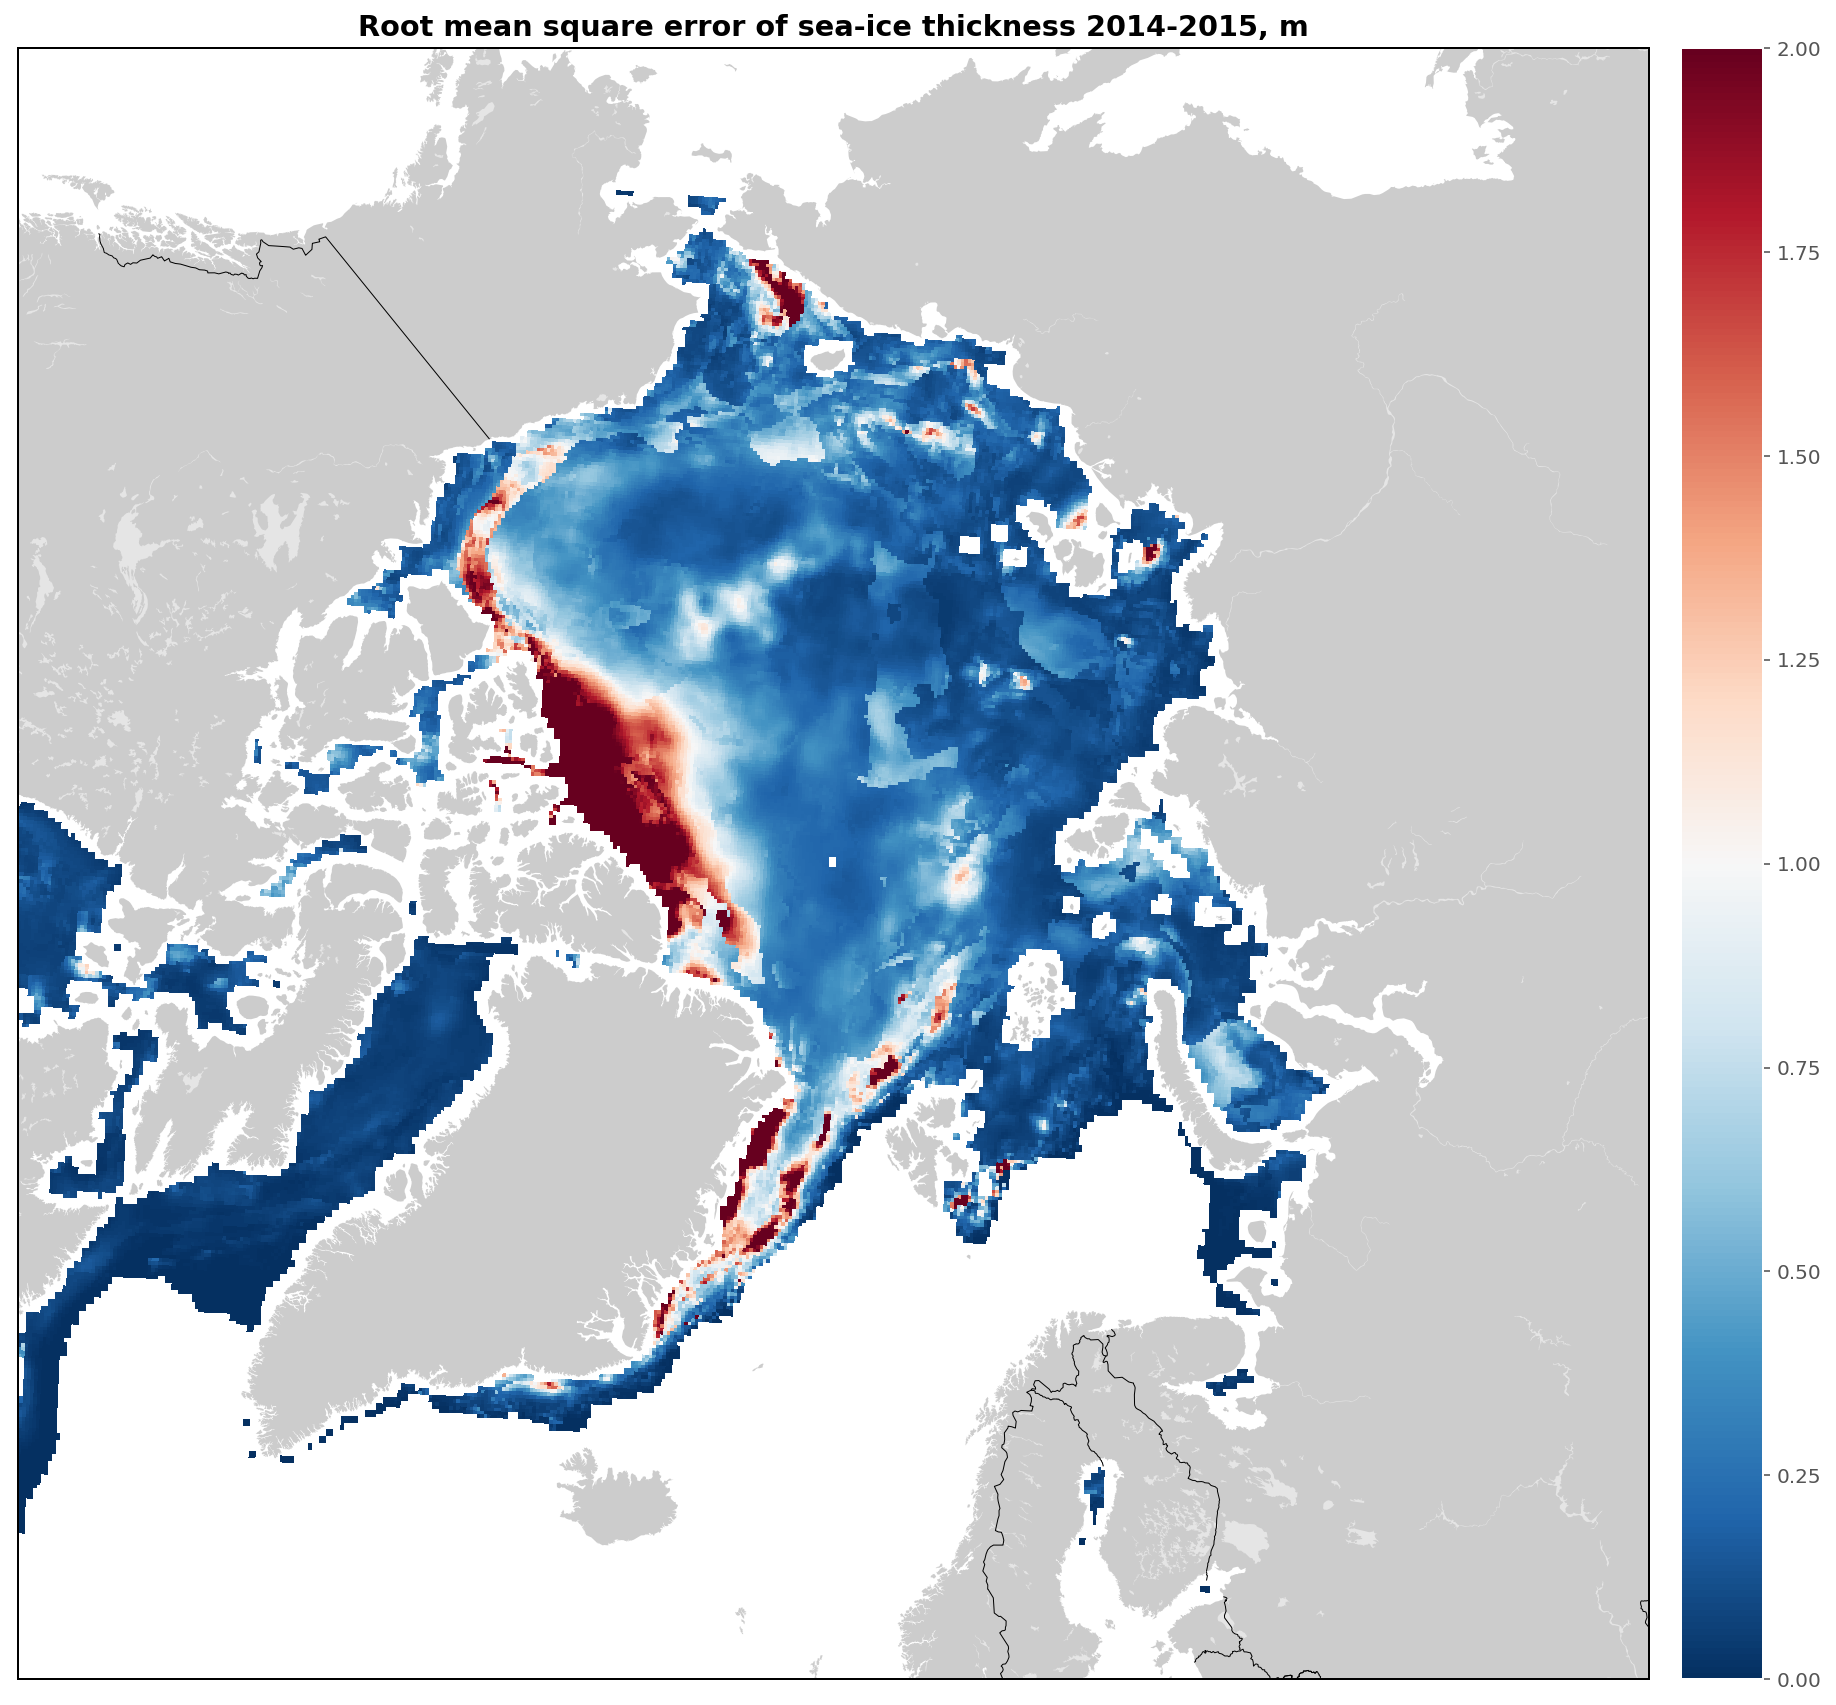

In [77]:
plot_map(rmse3d(ice_sat, res), vmin=0, vmax=2)
plt.title('Root mean square error of sea-ice thickness 2014-2015, m',  weight = 'bold')

Text(0.5, 1.0, 'Root mean square error of sea-ice thickness 2014-2015, m')

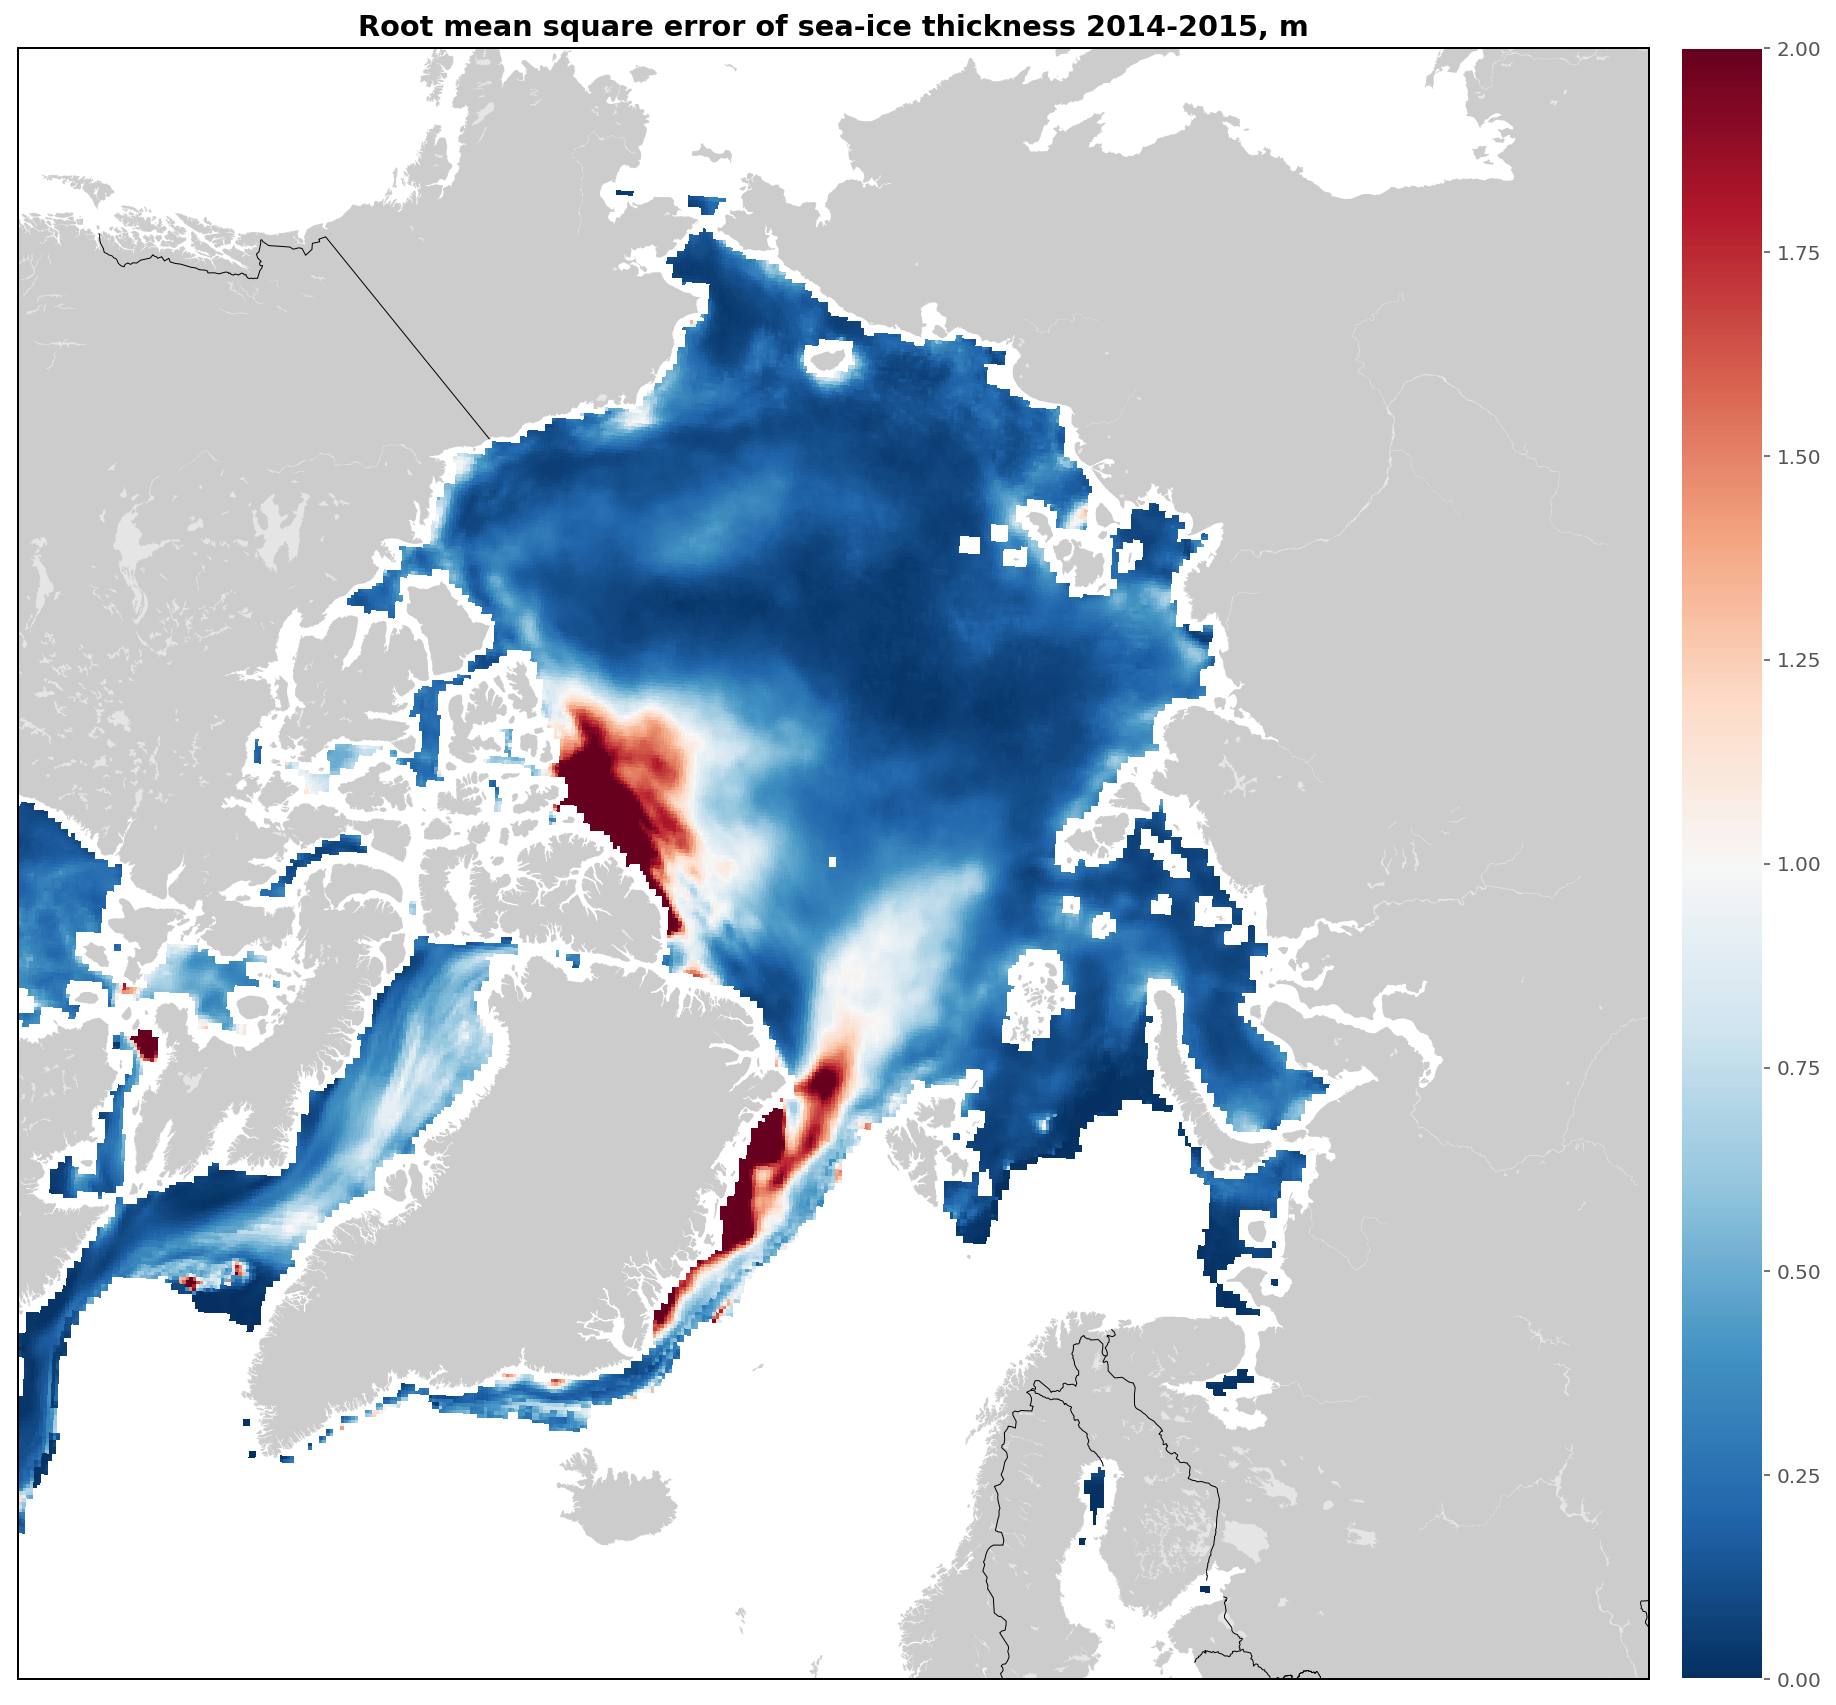

In [78]:
plot_map(rmse3d(ice_sat, NEMO), vmin=0, vmax=2)
plt.title('Root mean square error of sea-ice thickness 2014-2015, m',  weight = 'bold')

Text(0.5, 1.0, 'Mean absolute error of sea-ice thickness 2014-2015, m')

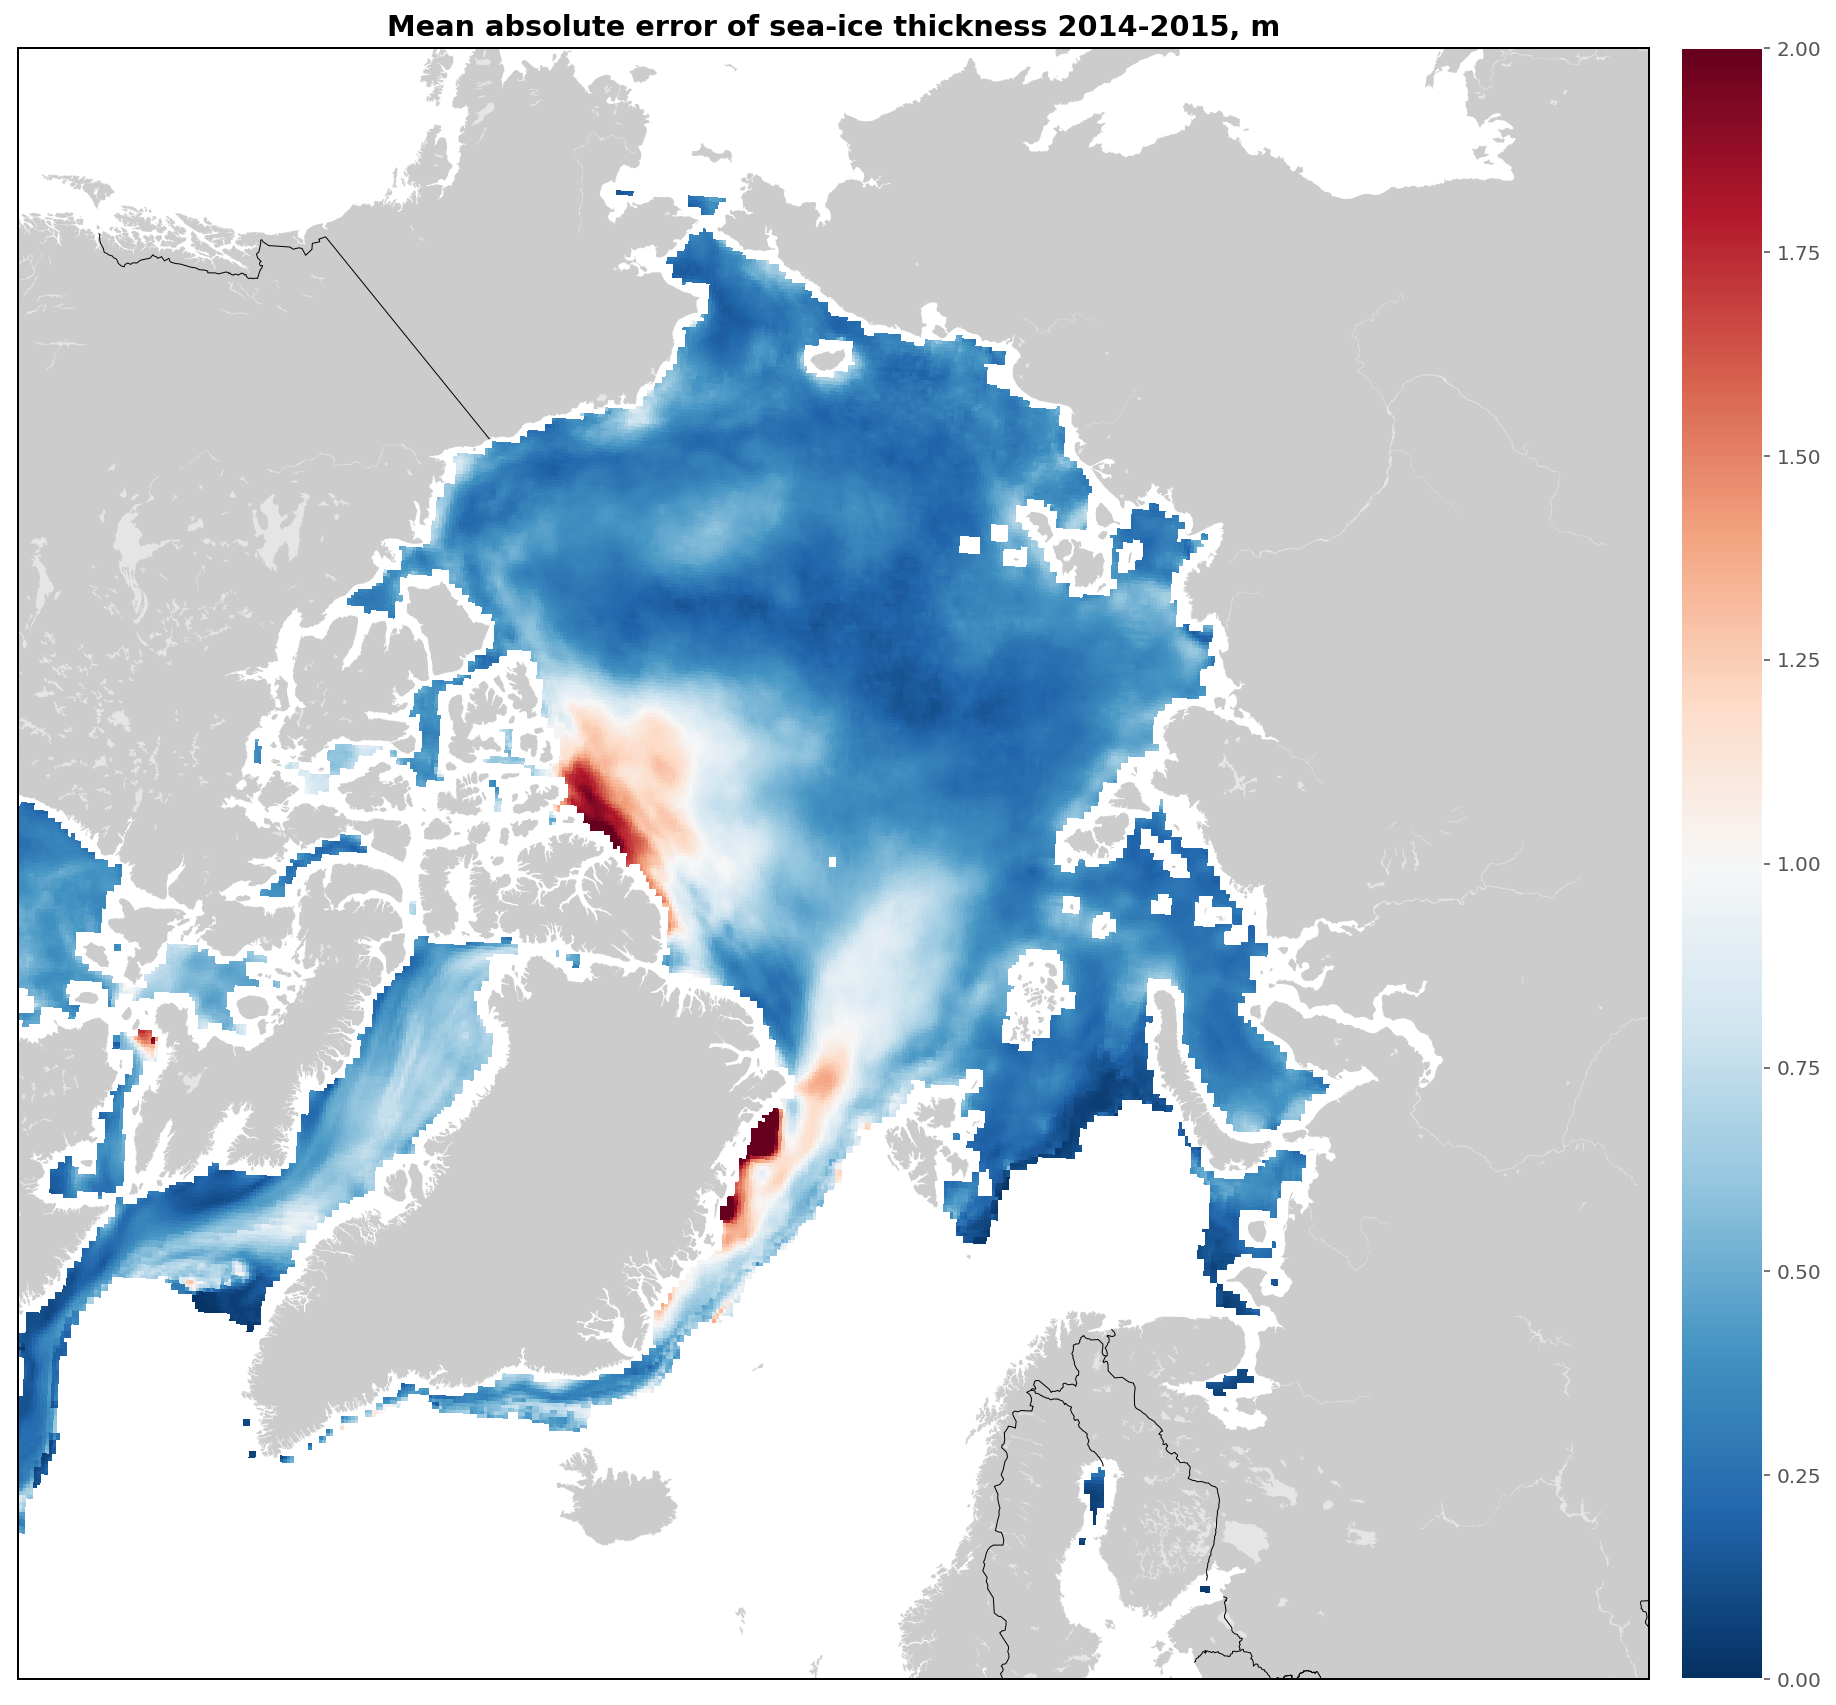

In [58]:
plot_map(MAE3d(ice_sat, NEMO), vmin=0, vmax=2)
plt.title('Mean absolute error of sea-ice thickness 2014-2015, m',  weight = 'bold')

409.06918
0.0


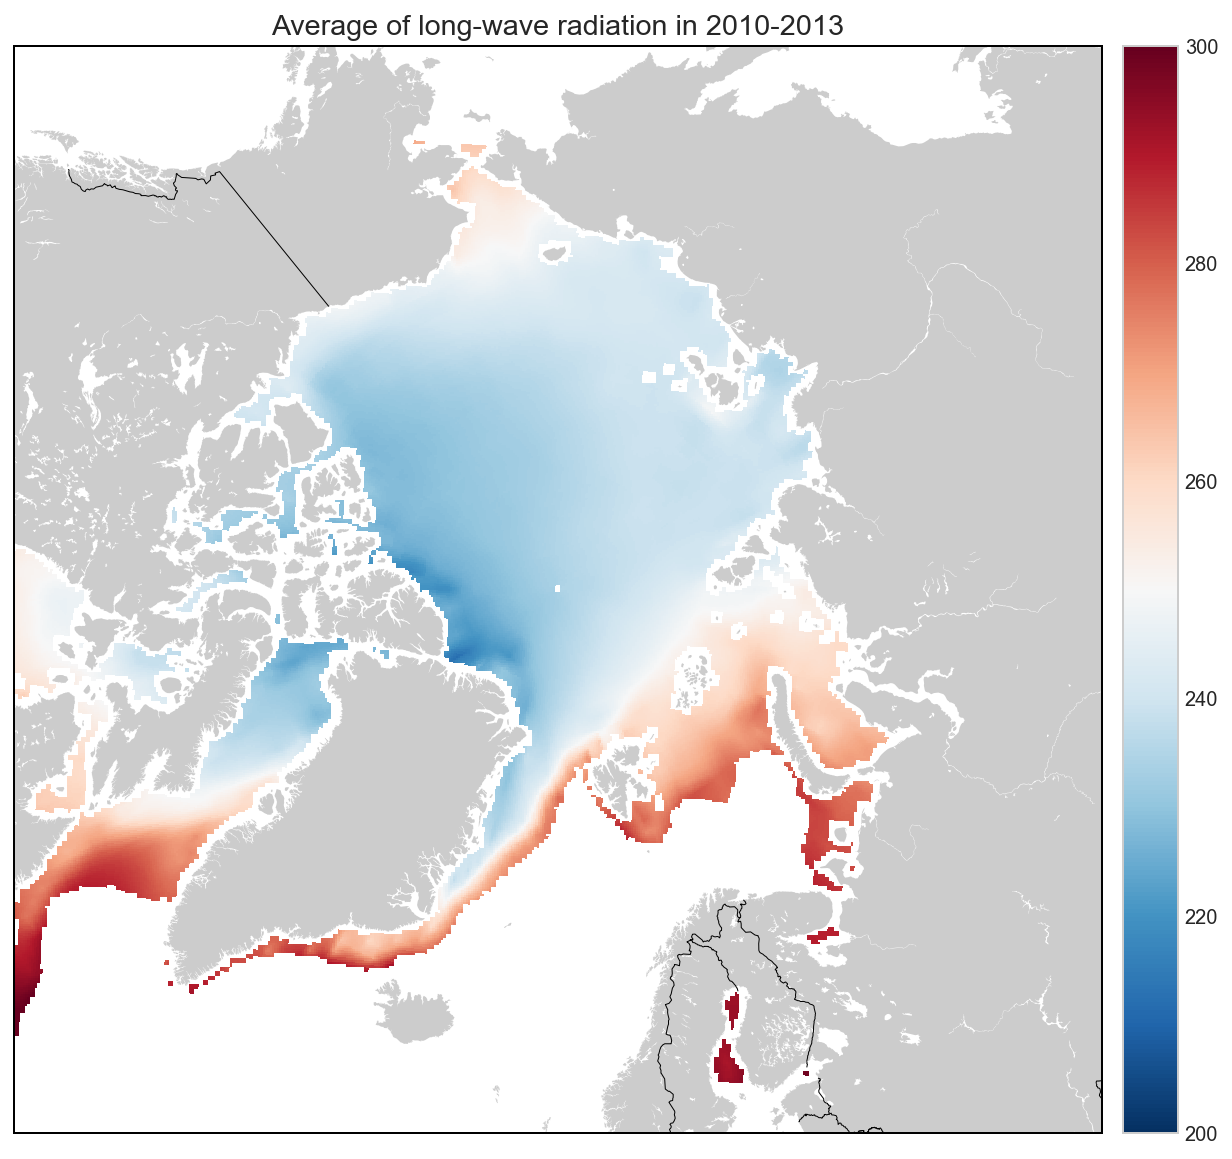

In [108]:
X_vars_names=['sattelite-measured sea ice concentration','NEMO sea ice thickness', 'air temperature','NEMO surface salinity','long-wave radiation']
X_vars=['ice_conc','icethic_cea', 'tair','vosaline','radlw']

i=4
_ = dset.load_variable_years(X_vars[i],list(range(2010, 2014)))
_ = apply2dmask(_, ice_line)
avg = np.nanmean(_, axis=0)
print(np.nanmax(_))
print(np.nanmin(_))

plot_map(avg, vmin=200, vmax=300)
plt.title(f'Average of {X_vars_names[i]} in 2010-2013')
plt.show()

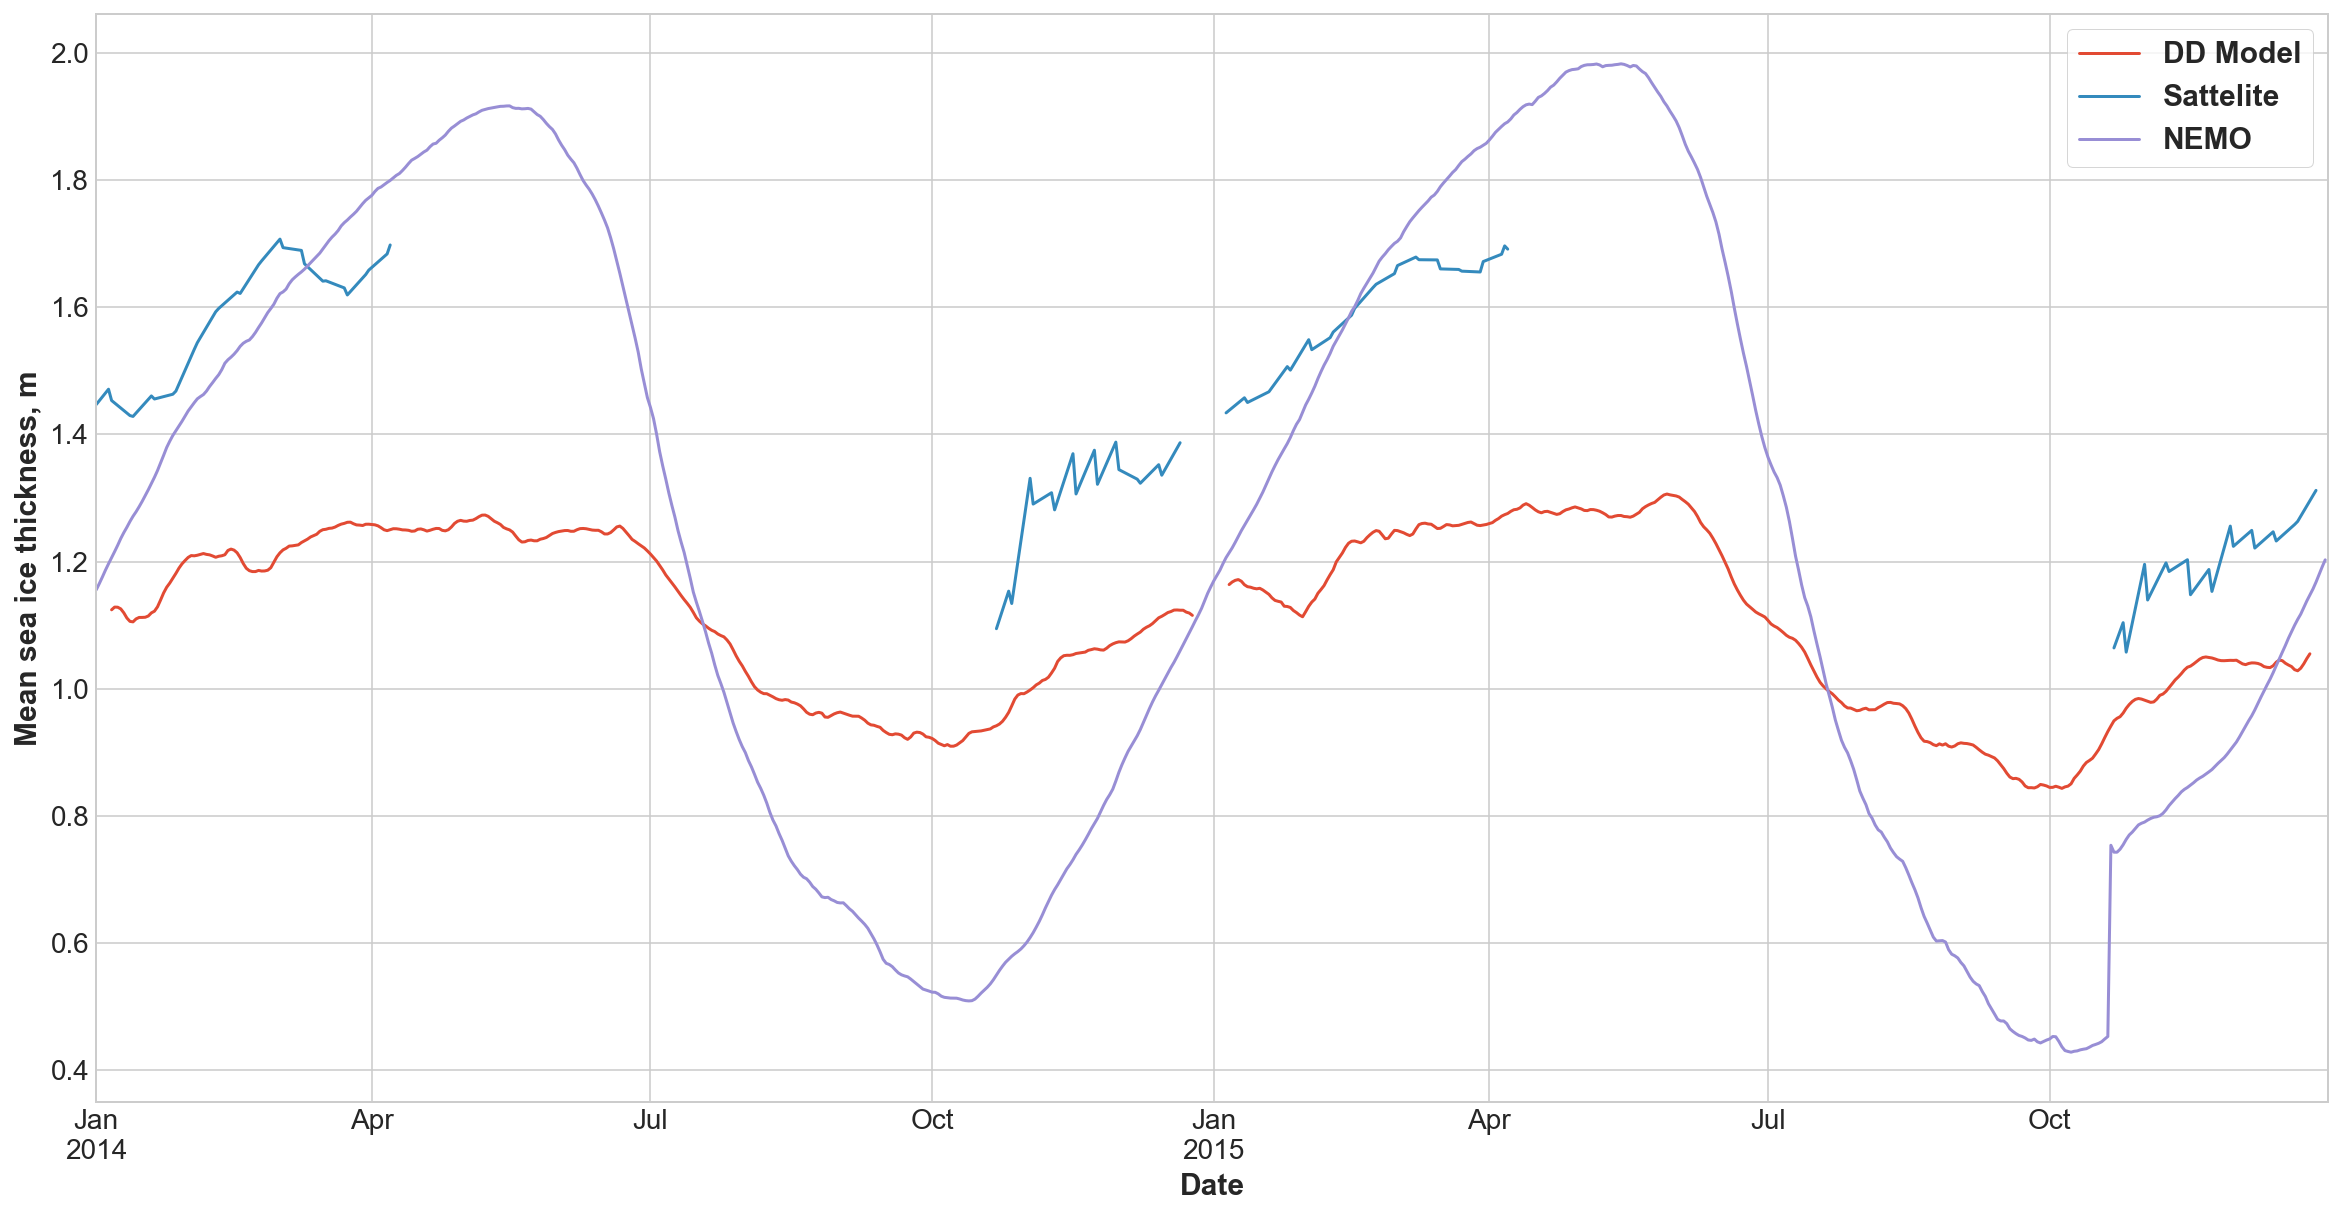

In [104]:
mean_dd = []
mean_sat = []
mean_nemo = []
for t in range(res.shape[0]):
    mean_dd.append(np.nanmean(res[t,:,:]))
    mean_sat.append(np.nanmean(ice_sat[t,:,:]))
    mean_nemo.append(np.nanmean(NEMO[t,:,:]))
    
plt.rcParams['figure.figsize'] = [20, 10]
mean_df = pd.DataFrame({'DD Model':mean_dd,
                       'Sattelite':mean_sat,
                       'NEMO':mean_nemo}, index=dates)

mean_df[mean_df==0] = np.nan
mean_df.plot()

axes = plt.gca()
#axes.set_ylim([0.2,0.8])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Date',fontsize = 15, weight = 'bold')
plt.ylabel('Mean sea ice thickness, m',fontsize = 15, weight = 'bold')
plt.legend(loc=1, prop={'size': 15,'weight':'bold'}, frameon=True)